
# Low-quality dataset generator (fixed-grid, DeepONet-aligned)

This notebook mirrors the interface of `ode_to_deeponet_dataset_scipy.ipynb` (same variable names, function signatures, and options like `spit: bool`),
but generates the dataset using a **fixed-grid solver** and **direct GRF sampling via Cholesky**, consistent with the lightweight approach in your `deeponet_pde.py` stack.

> ODE solved: **v'(x) = u(x), v(x_min)=0** (antiderivative).  
> Integrator: **composite trapezoidal cumulative integral** on a uniform grid.


## Faster than `generate_dataset_ODE`, but less precise

This notebook builds the same DeepONet-aligned dataset as `generate_dataset_ODE` (same names, parameters, and `split/spit: bool` option), but trades solver accuracy for higher throughput.

### How this notebook generates the dataset (fast “low-quality” path)
1. **Input functions $u(x)$ via GRF**
   - Draw $u$ on a fine grid $[x_{\min}, x_{\max}]$ from a Gaussian Random Field (kernel: RBF or Matern-1/2) using **Cholesky sampling**: if $K$ is the covariance matrix on the fine grid, sample $u = Lz$ with $LL^{\top} = K$ and $z \sim \mathcal{N}(0,I)$.
   - Use **equal coverage** over bins for length scale $\ell$ and variance $\sigma$ (from `length_scale_edges`, `sigma_edges`).
   - Interpolate $u$ to the branch/trunk grids (cubic by default).
2. **Solve the operator $v'(x)=u(x),\ v(x_{\min})=0$ on a fixed grid**
   - Compute $v$ on the trunk grid via **composite trapezoidal cumulative integration** (uniform step $h$):  
     $v_{j+1} = v_j + \tfrac{h}{2}\big(u_j + u_{j+1}\big)$, with $v_0=0$.
   - Very fast and vectorizable, but **no adaptive error control**.
3. **DeepONet packaging & saving**
   - **Branch inputs:** $u$ at `in_size_branch` uniform **sensor** points.  
   - **Trunk inputs:** shared evaluation grid of size `N_grid` (typically `N_grid == in_size_branch`).  
   - **Outputs:** $v$ on the trunk grid.  
   - Saves `antiderivative_aligned_train.npz` and `antiderivative_aligned_test.npz` if `split/spit=True`; otherwise `antiderivative_aligned_data.npz`.

### How `generate_dataset_ODE` generates the dataset (slower, higher-precision path)
1. **Same GRF inputs and equal-coverage over $(\ell,\sigma)$**
   - Draw $u$ on a fine grid; interpolate to sensors and trunk as above.
2. **Solve the operator with an adaptive ODE solver**
   - Use `scipy.integrate.solve_ivp` (e.g., **RK45** or **DOP853**) with specified `rtol/atol`.
   - Optionally run a **“moderate vs tight”** accuracy pass and record precision stats.
   - Provides **tighter error control** (and is more robust for nonlinear RHS), but is **slower** per sample.
3. **Same DeepONet packaging & saving** as above.

### When to use which
- **This notebook (fast, low-quality):** ideal for **large datasets** and quick iterations on the antiderivative operator; accuracy is generally adequate and generation is **much faster**.  
- **`generate_dataset_ODE` (precise):** use when you need **strict error control** or plan to extend to **nonlinear/stiffer** dynamics; expect **higher compute cost** per sample.

**File structure (both notebooks)**  
- `X` is a length-2 object array with `X[0] = branch_inputs (N_samples, in_size_branch)` and `X[1] = trunk_inputs (N_grid, 1)`.  
- `y = outputs (N_samples, N_grid)`.

In [1]:
# %pip install -q tqdm  # if tqdm is not installed

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Literal, Callable
from scipy.interpolate import interp1d

# ------------------ Configuration ------------------
seed = 123

# Dimensions (default aligned DeepONet shapes)
N_samples      = 150*10
in_size_branch = 100*10
N_grid         = in_size_branch
x_min, x_max   = 0.0, 1.0

# Equal-coverage parameter grid (edges)
length_scale_edges = np.linspace(0.1, 1, 5+1)
sigma_edges        = np.geomspace(0.1, 2.0, 5+1)
sigma_space        = "log"

# GRF kernel & sampling
kernel: Literal["RBF","Matern12"] = "RBF"
N_gp         = 1000
interp_kind  = "cubic"

# “Moderate vs tight” placeholders to keep signature compatible
method_lo, rtol_lo, atol_lo = "RK45",  1e-6,  1e-9
method_hi, rtol_hi, atol_hi = "DOP853",1e-10, 1e-13

# Saving options (same names as your SciPy notebook)
spit          = True
test_fraction = 0.2
train_fname   = "antiderivative_aligned_train.npz"
test_fname    = "antiderivative_aligned_test.npz"
single_fname  = "antiderivative_aligned_data.npz"

np.random.seed(seed)
print(f"N_samples={N_samples}, in_size_branch={in_size_branch}, N_grid={N_grid}, spit={spit}")
print(f"GRF: {kernel}, ℓ-edges={length_scale_edges}, σ-edges={sigma_edges}, N_gp={N_gp}, interp='{interp_kind}'")

N_samples=1500, in_size_branch=1000, N_grid=1000, spit=True
GRF: RBF, ℓ-edges=[0.1  0.28 0.46 0.64 0.82 1.  ], σ-edges=[0.1        0.18205642 0.3314454  0.60341763 1.09856054 2.        ], N_gp=1000, interp='cubic'


In [2]:
from numpy.linalg import cholesky

# Robust tqdm import (works in notebooks and terminals)
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(*args, **kwargs):
        class _NoBar:
            def update(self, *a, **k): pass
            def close(self): pass
            def __iter__(self): return iter(args[0] if args else [])
        return _NoBar()

def _pairwise_sqdist_1d(x: np.ndarray) -> np.ndarray:
    x = x.ravel()
    return (x[:, None] - x[None, :])**2

def _kernel_matrix_1d(x: np.ndarray, ell: float, sig: float, kind: str) -> np.ndarray:
    d2 = _pairwise_sqdist_1d(x)
    if kind == "RBF":
        K = (sig**2) * np.exp(-0.5 * d2 / (ell**2 + 1e-12))
    elif kind in {"Matern12", "AE", "AbsExp"}:
        d = np.sqrt(d2 + 1e-12)
        K = (sig**2) * np.exp(-d / (ell + 1e-12))
    else:
        raise ValueError(f"Unsupported kernel '{kind}'. Use 'RBF' or 'Matern12'.")
    return K

def _cumtrapz_uniform(y: np.ndarray, x0: float, h: float) -> np.ndarray:
    """Cumulative trapezoidal integral on a uniform grid starting at v(x0)=0."""
    y = np.asarray(y).ravel()
    v = np.zeros_like(y, dtype=float)
    if len(y) >= 2:
        v[1:] = np.cumsum((y[:-1] + y[1:]) * 0.5) * h
    return v

def _equal_coverage_bins(n_total: int, n_ell: int, n_sig: int):
    """Counts per (i,j) cell, nearly uniform and summing to n_total."""
    num_cells = n_ell * n_sig
    base = n_total // num_cells
    rem  = n_total %  num_cells
    counts = np.full((n_ell, n_sig), base, dtype=int)
    if rem > 0:
        idxs = np.arange(num_cells)[:rem]
        counts.ravel()[idxs] += 1
    return counts

def rhs_from_interpolant(u_interp: Callable[[np.ndarray], np.ndarray]) -> Callable[[float, float], np.ndarray]:
    """Match the SciPy notebook API: returns f(x, v) = u(x)."""
    def f(x: float, v: float):
        return np.array([float(u_interp(np.array([x]))[0])])
    return f

def build_dataset_grf(
    N_samples: int,
    in_size_branch: int,
    N_grid: int,
    x_min: float,
    x_max: float,
    *,
    length_scale_edges,                 # 1D array of bin edges for ℓ, shape (n_ell+1,)
    sigma_edges,                        # 1D array of bin edges for σ, shape (n_sig+1,)
    sigma_space: str = "log",           # "log" -> geometric interpolation; "linear" -> arithmetic
    kernel: str = "RBF",                # "RBF" | "Matern12"
    N_gp: int = 1000,                   # fine grid for GP draw
    interp_kind: str = "cubic",
    method_lo: str = "RK45", rtol_lo: float = 1e-6,  atol_lo: float = 1e-9,   # kept for signature compatibility
    method_hi: str = "DOP853", rtol_hi: float = 1e-10, atol_hi: float = 1e-13,
    seed: int = 123,
    normalize: str = "maxint",            # MODIFICA: Cambiato da bool a str
    return_meta: bool = True
):
    """
    Generate a DeepONet-aligned dataset for v'(x)=u(x), v(x_min)=0 with GRF inputs,
    using equal coverage over (ℓ, σ) bins and a fixed-grid cumulative trapezoid for v.

    Returns: branch_inputs, trunk_inputs, outputs, precision_stats_avg, meta
    """
    rng = np.random.RandomState(seed)   # used only for GP draws

    # Grids
    branch_x = np.linspace(x_min, x_max, in_size_branch)
    trunk_x  = np.linspace(x_min, x_max, N_grid)
    trunk_inputs = trunk_x.reshape(-1, 1)
    gp_x = np.linspace(x_min, x_max, N_gp)

    # Bin edges
    ell_edges = np.asarray(length_scale_edges, dtype=float)
    sig_edges = np.asarray(sigma_edges, dtype=float)
    n_ell = len(ell_edges) - 1
    n_sig = len(sig_edges) - 1
    if n_ell <= 0 or n_sig <= 0:
        raise ValueError("length_scale_edges and sigma_edges must each have at least two values.")

    # Storage
    branch_inputs = np.zeros((N_samples, in_size_branch), dtype=float)
    outputs       = np.zeros((N_samples, N_grid), dtype=float)
    ell_list      = np.zeros(N_samples, dtype=float)
    sigma_list    = np.zeros(N_samples, dtype=float)
    # MODIFICA: Unificato in 'scales'
    scales        = np.ones(N_samples, dtype=float)

    # Equal coverage counts per cell
    counts = _equal_coverage_bins(N_samples, n_ell, n_sig)
    sample_idx = 0

    # Helper for picking ℓ, σ inside a bin [edge_i, edge_{i+1}]
    def _within(lo, hi, space: str, pos: float):
        pos = float(pos)
        if space == "log":
            return float(np.exp(np.log(lo) + (np.log(hi) - np.log(lo)) * pos))
        else:
            return float(lo + (hi - lo) * pos)

    # Progress bar
    pbar = tqdm(total=N_samples, desc="Building dataset", unit="sample", leave=False)

    try:
        for i in range(n_ell):
            for j in range(n_sig):
                n_here = counts[i, j]
                if n_here == 0:
                    continue
                # centered fractional positions in (0,1): 0.5/n, 1.5/n, ..., (n-0.5)/n
                positions = (np.arange(n_here) + 0.5) / n_here
                for p in positions:
                    ell  = _within(ell_edges[i], ell_edges[i+1], "linear", p)
                    sig  = _within(sig_edges[j], sig_edges[j+1], sigma_space, p)

                    # --- GRF draw on gp_x via Cholesky ---
                    K = _kernel_matrix_1d(gp_x, ell, sig, kernel)
                    K.flat[::K.shape[0]+1] += 1e-12  # jitter
                    L = cholesky(K)
                    z = rng.standard_normal(N_gp)
                    u_gp = L @ z
                    u_interp = interp1d(gp_x, u_gp, kind=interp_kind, fill_value="extrapolate", assume_sorted=True)

                    # Evaluate on branch/trunk grids
                    u_branch = u_interp(branch_x).astype(float)
                    u_trunk  = u_interp(trunk_x).astype(float)

                    # Fixed-grid cumulative trapezoid to get v on trunk grid, v(x_min)=0
                    h = (x_max - x_min) / max(1, N_grid - 1)
                    v_trunk = _cumtrapz_uniform(u_trunk, x_min, h)

                    # --- MODIFICA BLOCCO NORMALIZZAZIONE ---
                    M = 1.0 # Default scale
                    if normalize == "maxint" or normalize is True: # Gestisce "maxint" e la vecchia chiamata bool=True
                        # Logica "maxint": normalizza sul max dell'integrale
                        M = np.max(np.abs(v_trunk)) + 1e-12 
                        u_branch = u_branch / M
                        v_trunk  = v_trunk  / M
                    elif normalize == "rms":
                        # Vecchia logica (RMS separati, non preserva la scala)
                        s_u = np.sqrt(np.mean(u_branch**2) + 1e-12)
                        s_v = np.sqrt(np.mean(v_trunk**2) + 1e-12)
                        u_branch = u_branch / s_u
                        v_trunk  = v_trunk  / s_v
                        M = s_u # Salva solo lo scale dell'input
                    # Se normalize==False o None, M resta 1.0
                    # --- FINE BLOCCO MODIFICATO ---


                    # Store
                    branch_inputs[sample_idx, :] = u_branch
                    outputs[sample_idx, :]       = v_trunk
                    ell_list[sample_idx]         = ell
                    sigma_list[sample_idx]       = sig
                    # MODIFICA: Salva lo scale M
                    scales[sample_idx]           = M

                    sample_idx += 1
                    pbar.update(1)
                    if sample_idx >= N_samples:
                        break
                if sample_idx >= N_samples:
                    break
            if sample_idx >= N_samples:
                break
    finally:
        pbar.close()

    # Interface compatibility: no dual-precision here
    precision_stats_avg = {"err_mean": 0.0, "err_max": 0.0, "err_rmse": 0.0}

    # --- MODIFICA DIZIONARIO META ---
    meta = {
        "ell":     ell_list[:sample_idx],
        "sigma":   sigma_list[:sample_idx],
    }
    if normalize: # Aggiunge la chiave 'scales' solo se la normalizzazione è avvenuta
        meta["scales"] = scales[:sample_idx]
    # --- FINE MODIFICA META ---

    return branch_inputs, trunk_inputs, outputs, precision_stats_avg, meta

def save_npz_files(branch_inputs, trunk_inputs, outputs, spit: bool,
                   test_fraction: float, train_fname: str, test_fname: str, single_fname: str):
    """Save DeepONet-aligned .npz files with object-array X=[branch, trunk] and y."""
    def pack_X(branch, trunk):
        return np.array([branch, trunk], dtype=object)

    N = branch_inputs.shape[0]
    if spit:
        N_test = max(1, int(round(N * test_fraction)))
        N_train = N - N_test
        idx = np.arange(N); np.random.shuffle(idx)
        tr_idx, te_idx = idx[:N_train], idx[N_train:]

        X_train = pack_X(branch_inputs[tr_idx], trunk_inputs)
        y_train = outputs[tr_idx]
        X_test  = pack_X(branch_inputs[te_idx],  trunk_inputs)
        y_test  = outputs[te_idx]

        np.savez(train_fname, X=X_train, y=y_train)
        np.savez(test_fname,  X=X_test,  y=y_test)

        print(f"Saved: {train_fname}  with X[0].shape={X_train[0].shape}, X[1].shape={X_train[1].shape}, y.shape={y_train.shape}")
        print(f"Saved: {test_fname}   with X[0].shape={X_test[0].shape},  X[1].shape={X_test[1].shape},  y.shape={y_test.shape}")
    else:
        X = pack_X(branch_inputs, trunk_inputs)
        y = outputs
        np.savez(single_fname, X=X, y=y)
        print(f"Saved: {single_fname} with X[0].shape={X[0].shape}, X[1].shape={X[1].shape}, y.shape={y.shape}")

In [3]:

# Build and save the dataset (low-quality, fixed-grid)
branch_inputs, trunk_inputs, outputs, prec_stats, meta = build_dataset_grf(
    N_samples, in_size_branch, N_grid, x_min, x_max,
    length_scale_edges=length_scale_edges,
    sigma_edges=sigma_edges,
    sigma_space=sigma_space,
    kernel=kernel,
    N_gp=N_gp,
    interp_kind=interp_kind,
    method_lo=method_lo, rtol_lo=rtol_lo, atol_lo=atol_lo,
    method_hi=method_hi, rtol_hi=rtol_hi, atol_hi=atol_hi,
    seed=seed,
    normalize=True,
    return_meta=True
)

save_npz_files(branch_inputs, trunk_inputs, outputs, spit, test_fraction, train_fname, test_fname, single_fname)

print("\nPrecision (moderate vs tight surrogate):", prec_stats)
print(f"Meta keys: {list(meta.keys())} (len={len(meta['ell'])})")


Building dataset:   0%|          | 0/1500 [00:00<?, ?sample/s]

Saved: antiderivative_aligned_train.npz  with X[0].shape=(1200, 1000), X[1].shape=(1000, 1), y.shape=(1200, 1000)
Saved: antiderivative_aligned_test.npz   with X[0].shape=(300, 1000),  X[1].shape=(1000, 1),  y.shape=(300, 1000)

Precision (moderate vs tight surrogate): {'err_mean': 0.0, 'err_max': 0.0, 'err_rmse': 0.0}
Meta keys: ['ell', 'sigma', 'scales'] (len=1500)


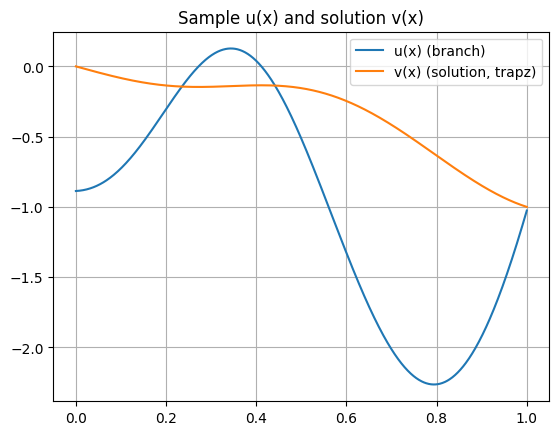

In [8]:

# Quick sanity plots
idx = 52
plt.plot(np.linspace(x_min, x_max, in_size_branch), branch_inputs[idx], label="u(x) (branch)")
plt.plot(trunk_inputs[:, 0], outputs[idx], label="v(x) (solution, trapz)")
plt.legend(); plt.grid(); plt.title("Sample u(x) and solution v(x)"); plt.show()


In [48]:

# Reload and verify (remember allow_pickle=True on load)
if spit:
    tr = np.load(train_fname, allow_pickle=True)
    te = np.load(test_fname,  allow_pickle=True)
    print("Train shapes:", tr["X"][0].shape, tr["X"][1].shape, tr["y"].shape)
    print("Test shapes: ", te["X"][0].shape, te["X"][1].shape, te["y"].shape)
else:
    da = np.load(single_fname, allow_pickle=True)
    print("Data shapes:", da["X"][0].shape, da["X"][1].shape, da["y"].shape)


Train shapes: (1200, 1000) (1000, 1) (1200, 1000)
Test shapes:  (300, 1000) (1000, 1) (300, 1000)
